# CNN for Sentence Similarity

** Purpose **

We want to make a binary classifier that takes a pair of sentences and judge whether they belong to the same group or not, and then help a downstream cluster (e.g. HAC) w/ it. 

* Let $x_1$, $x_2$ be two sentences (encoded in integer indices) of lengths $l_1$, $l_2$ respectively, then we first pad them to be of length $l$, and then embed their consisting words in $d$ dimensional space to produce two matrices $X_1^{l\times d}, X_2^{l\times d}$.
* We then convolve on the matrices with filters of shapes $(3\times d), (4\times d)$ and $(5\times d)$. This results in vectors of the shape $(l-3+1, 1), (l-4+1, 1)$ and $(l-5+1, 1)$ (with 'VALID', i.e. narrow convolution), for each filter size (i.e. $3, 4$ and $5$). With $k$ filters per filter size, we end up with vectors $((l-3+1)\times k, 1), ((l-4+1)\times k, 1)$ and $((l-5+1)\times k, 1)$. For $x_1$, call them $h_1^3, h_1^4, h_1^5$, on which we do ReLU nonlinearity: $$h = \texttt{ReLU}(h)$$
* Performing max-pooling on the above and concatenate results, we get a single vector representation for each of the two sentences, of shape $(3k,)$, for the two sentences we get $h_{pool1}, h_{pool2}$, we then put them through dropout regularization with probability $p$: $$h_{pool} = \texttt{Dropout}(h_{pool}, p)$$
* Finally we do a bilinear transformation on these vectors to make logits: $$\texttt{Logit}(x_{pool1}, x_{pool2}) = \sigma(x_{pool1}^T W^{3k\times 3k} x_{pool2})$$
from which we get the loss $\mathcal{L}$: $$\mathcal{L} = \texttt{Cross-Ent}(\texttt{Logit}(x_{pool1}, x_{pool2}), y)$$
where $y$ is the true label.
where 
* Finally, the prediction is made by rounding the logit: $$\hat{y} = \texttt{Round}(\texttt{Logit}(x_{pool1}, x_{pool2}))$$
where $\texttt{Round}$ returns $1$ if the sigmoid probability is greater than $0.5$ and $0$ otherwise.

### Prepare data

In [1]:
import sys
sys.path.append('/Users/jacob.su.wang/Desktop/CODER/TENSORFLOW/SCRIPTS')

In [2]:
import random
from helpers import Indexer
from mock_sentence_similarity import *

In [3]:
indexer = Indexer()
glove_embeddings = get_dict_and_embeddings(VOCAB, indexer)

In [4]:
print(generate_pos_datum(19))
print(generate_neg_datum(14))

(array(['dog', 'pig', 'horse', 'horse', 'pig', 'pig', 'deer', 'cat', 'deer',
       'horse', 'cat', 'dog', 'horse', 'cat', 'dog', 'horse', 'horse',
       'cat', 'dog'],
      dtype='<U5'), array(['deer', 'horse', 'dog', 'cat', 'cat', 'deer', 'dog', 'deer',
       'horse', 'dog', 'cat', 'horse', 'deer', 'dog', 'cat', 'cat', 'cat',
       'pig', 'cat'],
      dtype='<U5'))
(array(['pig', 'horse', 'dog', 'pig', 'dog', 'horse', 'dog', 'pig', 'cat',
       'deer', 'horse', 'pig', 'deer', 'horse'],
      dtype='<U5'), array(['bus', 'car', 'car', 'train', 'motorcycle', 'truck', 'motorcycle',
       'bus', 'truck', 'train', 'bus', 'bus', 'train', 'train'],
      dtype='<U10'))


In [5]:
x1, x2, y = generate_batch(indexer, len_from=2, len_to=5, batch_size=2)
print(x1)
print(x2)
print(y)

[[ 1  0 10 10 10]
 [ 5  5  8 10 10]]
[[ 8  5 10 10 10]
 [ 6  9  8 10 10]]
[0 1]


### Model

In [6]:
import tensorflow as tf

In [10]:
tf.reset_default_graph()

LEN_FROM, LEN_TO = 5, 15
MAX_LEN = 15
NUM_CLASSES = 2
VOCAB_SIZE = len(VOCAB) + 1
EMBED_SIZE = 20
FILTER_SIZES = [3,4,5]   # size types.
NUM_FILTERS = 10         # #filters per size type.
NUM_CHANNELS = 1

# sess = tf.InteractiveSession()
sess = tf.Session()

input_x1 = tf.placeholder(tf.int32, [None, MAX_LEN], name='input_x1')
input_x2 = tf.placeholder(tf.int32, [None, MAX_LEN], name='input_x2')
input_y  = tf.placeholder(tf.int32, [None], name='input_y')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

with tf.device('/cpu:0'), tf.variable_scope('embeddings'): 
        # name_scope works only with tf.Variable
        # variable_scope works with tf.get_variable
    E = tf.get_variable('E', [VOCAB_SIZE, EMBED_SIZE], initializer=tf.contrib.layers.xavier_initializer())
    embed_x1 = tf.expand_dims(tf.nn.embedding_lookup(E, input_x1), -1)
    embed_x2 = tf.expand_dims(tf.nn.embedding_lookup(E, input_x2), -1)
        # embed_x*: [batch_size, height=MAX_LEN, width=EMBED_SIZE, num_channels=1]

pool1_outputs, pool2_outputs = [], []
for i, filter_size in enumerate(FILTER_SIZES):
    with tf.variable_scope('conv-max-pool-%s' % filter_size): 
        filter_shape = [filter_size, EMBED_SIZE, NUM_CHANNELS, NUM_FILTERS]
            # Filter dims: [filter_size, emb_size, num_channels, num_filters]
        W1 = tf.get_variable('W1', filter_shape, initializer=tf.contrib.layers.xavier_initializer())
        W2 = tf.get_variable('W2', filter_shape, initializer=tf.contrib.layers.xavier_initializer())
        b1 = tf.get_variable('b1', [NUM_FILTERS], initializer=tf.contrib.layers.xavier_initializer())
        b2 = tf.get_variable('b2', [NUM_FILTERS], initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.nn.conv2d(embed_x1, W1, strides=[1,1,1,1], padding='VALID', name='conv1')
        conv2 = tf.nn.conv2d(embed_x2, W2, strides=[1,1,1,1], padding='VALID', name='conv2')
            # Conv dims: [batch_size, height, width, num_channels]
        h1 = tf.nn.relu(tf.nn.bias_add(conv1, b1), name='relu1')
        h2 = tf.nn.relu(tf.nn.bias_add(conv2, b2), name='relu2')
        pool1 = tf.nn.max_pool(h1, ksize=[1,MAX_LEN-filter_size+1,1,1], strides=[1,1,1,1], padding='VALID', name='pool1')
        pool2 = tf.nn.max_pool(h2, ksize=[1,MAX_LEN-filter_size+1,1,1], strides=[1,1,1,1], padding='VALID', name='pool2')
            # kernel size (ksize): [batch_size, height, width, num_channels]
        pool1_outputs.append(pool1)
        pool2_outputs.append(pool2)

num_filters_total = NUM_FILTERS * len(FILTER_SIZES)
h_pool1_flat = tf.nn.dropout(tf.reshape(tf.concat(pool1_outputs, 3), [-1, num_filters_total]), keep_prob)
h_pool2_flat = tf.nn.dropout(tf.reshape(tf.concat(pool2_outputs, 3), [-1, num_filters_total]), keep_prob)
    # flat shape: [batch_size, num_filters_total].
W_bi = tf.get_variable('W_bi', [num_filters_total, num_filters_total],
                       initializer=tf.contrib.layers.xavier_initializer())
scores = tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(h_pool1_flat, W_bi), tf.transpose(h_pool2_flat))))

predictions = tf.cast(tf.round(scores), tf.int32, name='predictions')

with tf.name_scope('loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses)

with tf.name_scope('accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-4)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [11]:
# Run model while saving
#   1. run init
#   2. init tf.train.Saver() object
#   3. specify save path
#   4. save after sess.run(..) # NB: global_step's imperative

NUM_EPOCHS = 1
NUM_BATCHES = 1000

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
save_path = '/Users/jacob.su.wang/Desktop/CODER/TENSORFLOW/CNN/SAVED/cnn-test1'

for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    loss_track, accuracy_track = [], []
    for b in range(NUM_BATCHES):
        batch_x1, batch_x2, batch_y = generate_batch(indexer, LEN_FROM, LEN_TO, batch_size=64)
        fd = {input_x1:batch_x1, input_x2:batch_x2, input_y:batch_y, keep_prob:0.7}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        loss_track.append(loss_)
        accuracy_track.append(accuracy_)
        if step%100==0:
            print('M.Loss = {} | M.Accuracy = {}'.format(np.mean(loss_track), np.mean(accuracy_track)))
    print('\n')
    
saver.save(sess, save_path, sess.run(global_step))

Epoch  1


M.Loss = 0.7222447395324707 | M.Accuracy = 0.5165625214576721
M.Loss = 0.7139453291893005 | M.Accuracy = 0.510546863079071
M.Loss = 0.708305299282074 | M.Accuracy = 0.5075520873069763
M.Loss = 0.704450249671936 | M.Accuracy = 0.5064843893051147
M.Loss = 0.7013000249862671 | M.Accuracy = 0.5061249732971191
M.Loss = 0.6969977021217346 | M.Accuracy = 0.5095833539962769
M.Loss = 0.6858866810798645 | M.Accuracy = 0.5452678799629211
M.Loss = 0.6687422394752502 | M.Accuracy = 0.5979297161102295
M.Loss = 0.652645468711853 | M.Accuracy = 0.6417534947395325
M.Loss = 0.638826310634613 | M.Accuracy = 0.6774218678474426




'/Users/jacob.su.wang/Desktop/CODER/TENSORFLOW/CNN/SAVED/cnn-test1-1000'

In [12]:
# Restore the stuff
#   1. init sess
#   2. get graph using tf.train.import_meta_graph(path/to/meta)
#   3. use obj created in step 2 to restore from check point
#   4. build a graph using tf.get_default_graph()
#   5. read input-end tensors (the shit you create feed_dict by) # don't forget naming.
#   6. read output-end tensors # don't forget naming.
#   7. run output-end tensor as usual

sess = tf.Session()
saver = tf.train.import_meta_graph(save_path+'-1000.meta')
saver.restore(sess, tf.train.latest_checkpoint('/Users/jacob.su.wang/Desktop/CODER/TENSORFLOW/CNN/SAVED/'))

graph = tf.get_default_graph()
input_x1 = graph.get_tensor_by_name('input_x1:0')
input_x2 = graph.get_tensor_by_name('input_x2:0')
keep_prob = graph.get_tensor_by_name('keep_prob:0')

test_x1 = [['motorcycle', 'train', 'motorcycle', 'car', 'car', 'car', 'train']]
test_x2 = [['motorcycle', 'train', 'train', 'car', 'bus']]
test_x3 = [['cat', 'cat', 'deer', 'deer', 'pig', 'dog', 'dog', 'deer', 'dog']]
def to_code(x_):
    return [[indexer.get_index(elem) for elem in pad_sentence(MAX_LEN, x_[0])]]
fd = {input_x1:to_code(test_x1), input_x2:to_code(test_x2), keep_prob:1.0}

predictions = graph.get_tensor_by_name('predictions:0')
print(sess.run(predictions, feed_dict=fd))

[1]


### Cust. Tests

In [18]:
# test x1 = x2; test x3 in another group.
test_x1 = [['motorcycle', 'train', 'motorcycle', 'car', 'car', 'car', 'train']]
test_x2 = [['motorcycle', 'train', 'train', 'car', 'bus']]
test_x3 = [['cat', 'cat', 'deer', 'deer', 'pig', 'dog', 'dog', 'deer', 'dog']]
test_y12 = [1]
test_y13 = [0]
test_y23 = [0]

def to_code(x_):
    return [[indexer.get_index(elem) for elem in pad_sentence(MAX_LEN, x_[0])]]

def predict(x1_, x2_, y_, sess_):
    fd = {input_x1:to_code(x1_), input_x2:to_code(x2_), input_y:test_y12, keep_prob:1.0}
    pred, conf = sess_.run([predictions, scores], feed_dict=fd)
    print('True = {} | Pred = {} (conf: {})'.format(y_, pred, conf if y_==[1] else 1-conf))

In [21]:
predict(test_x1, test_x2, test_y12, sess)
predict(test_x1, test_x3, test_y13, sess)
predict(test_x2, test_x3, test_y23, sess)

True = [1] | Pred = [1] (conf: [ 0.98743469])
True = [0] | Pred = [0] (conf: [ 0.99620718])
True = [0] | Pred = [0] (conf: [ 0.99533159])


In [20]:
to_code(test_x1)

[[7, 1, 7, 0, 0, 0, 1, 10, 10, 10, 10, 10, 10, 10, 10]]

### HAC w/ CNN sentence distance model

In [114]:
# Test run

X = to_code(test_x1) + to_code(test_x2) + to_code(test_x3)
    # x1, x2: vehicle sentence, x3: animal sentence.
print(X); print('\n')

def mydist(p1, p2):
    fd = {input_x1:[p1], input_x2:[p2], keep_prob:1.0}
    conf = sess.run(scores, feed_dict=fd)
    return 1-conf[0] # predict 0 means two sentences a far

print(mydist(X[1],X[2])) # expect far

[[7, 1, 7, 0, 0, 0, 1, 10, 10, 10, 10, 10, 10, 10, 10], [7, 1, 1, 0, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [6, 6, 8, 8, 9, 5, 5, 8, 5, 10, 10, 10, 10, 10, 10]]


0.995331563987


In [ ]:
# Mock run

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

def foo(n=5):
    # Generate some data
    # data: original strings
    # data_code: encoded data strings by indexer
    data = []
    data_code = []
    for _ in range(n):
        a_,b_ = generate_neg_datum(5)
        data += [a_, b_]
        data_code += [to_code_foo(a_), to_code_foo(b_)]
    return data, data_code

def to_code_foo(x_):
    return [indexer.get_index(elem) for elem in pad_sentence(MAX_LEN, x_)]

In [102]:
X1, X2 = foo()

In [104]:
print(list(enumerate(X1)))

[(0, array(['bus', 'truck', 'motorcycle', 'truck', 'train'],
      dtype='<U10')), (1, array(['pig', 'deer', 'dog', 'dog', 'deer'],
      dtype='<U5')), (2, array(['horse', 'horse', 'cat', 'horse', 'horse'],
      dtype='<U5')), (3, array(['motorcycle', 'motorcycle', 'bus', 'train', 'bus'],
      dtype='<U10')), (4, array(['truck', 'truck', 'truck', 'motorcycle', 'car'],
      dtype='<U10')), (5, array(['horse', 'deer', 'pig', 'pig', 'cat'],
      dtype='<U5')), (6, array(['horse', 'cat', 'pig', 'pig', 'dog'],
      dtype='<U5')), (7, array(['train', 'train', 'car', 'motorcycle', 'bus'],
      dtype='<U10')), (8, array(['motorcycle', 'train', 'bus', 'truck', 'bus'],
      dtype='<U10')), (9, array(['horse', 'deer', 'pig', 'cat', 'dog'],
      dtype='<U5'))]


In [105]:
X2

[[2, 3, 7, 3, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [9, 8, 5, 5, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [4, 4, 6, 4, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [7, 7, 2, 1, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [3, 3, 3, 7, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [4, 8, 9, 9, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [4, 6, 9, 9, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [1, 1, 0, 7, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [7, 1, 2, 3, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [4, 8, 9, 6, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]

In [107]:
print(mydist(X2[0],X2[3])) # expect close
print(mydist(X2[0],X2[1])) # expect far

0.0241961479187
0.977911744267


In [91]:
# np.set_printoptions(precision=5, suppress=True)

In [108]:
Z = linkage(X2, metric=mydist)

In [109]:
# Format of clustering results
#   [idx1, idx2, dist, sample_count]
#   idx1, idx2: cluster ids
#   idx1 and idx2 are merged with distance to create a cluster of size sample_count.
Z 

array([[  1.     ,   5.     ,   0.00294,   2.     ],
       [  9.     ,  10.     ,   0.00373,   3.     ],
       [  3.     ,   8.     ,   0.00579,   2.     ],
       [  6.     ,  11.     ,   0.00667,   4.     ],
       [  7.     ,  12.     ,   0.01347,   3.     ],
       [  0.     ,  14.     ,   0.01549,   4.     ],
       [  4.     ,  15.     ,   0.02349,   5.     ],
       [  2.     ,  13.     ,   0.03558,   5.     ],
       [ 16.     ,  17.     ,   0.92439,  10.     ]])

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

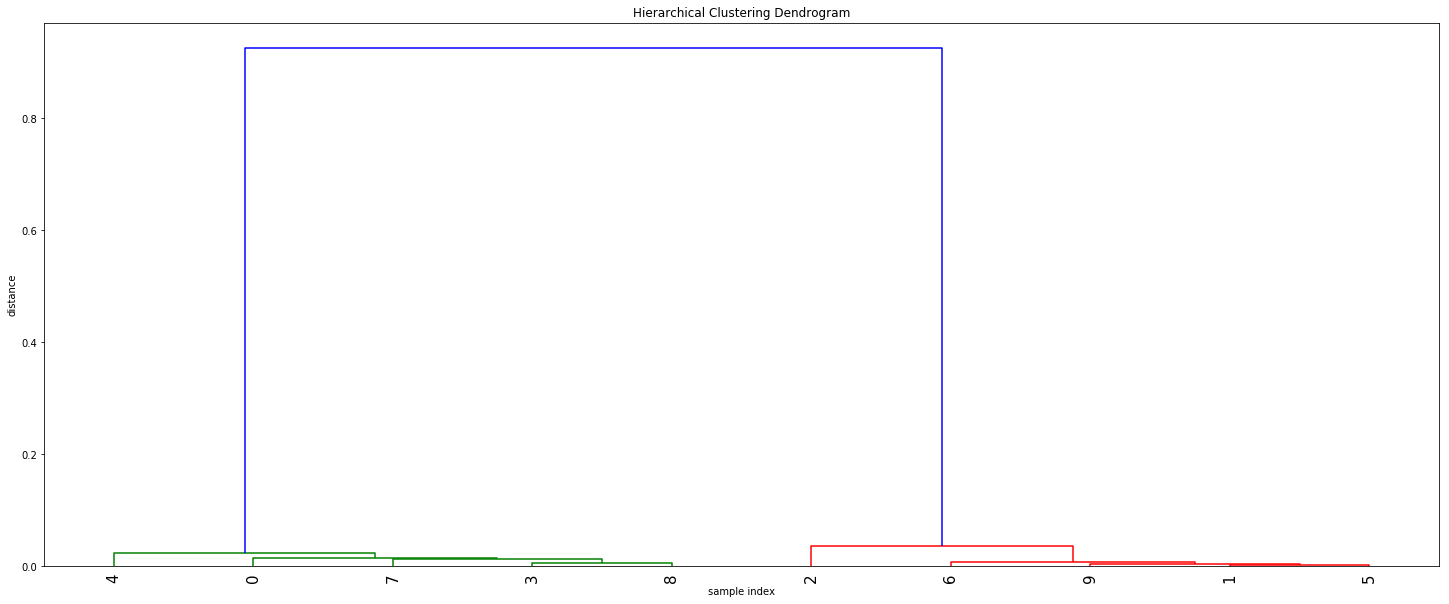

In [113]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=15.,  # font size for the x axis labels
)
plt.show()

In [ ]:
# As you can see, the separation is pretty dope.

# [(0, array(['bus', 'truck', 'motorcycle', 'truck', 'train'],
#       dtype='<U10')), (1, array(['pig', 'deer', 'dog', 'dog', 'deer'],
#       dtype='<U5')), (2, array(['horse', 'horse', 'cat', 'horse', 'horse'],
#       dtype='<U5')), (3, array(['motorcycle', 'motorcycle', 'bus', 'train', 'bus'],
#       dtype='<U10')), (4, array(['truck', 'truck', 'truck', 'motorcycle', 'car'],
#       dtype='<U10')), (5, array(['horse', 'deer', 'pig', 'pig', 'cat'],
#       dtype='<U5')), (6, array(['horse', 'cat', 'pig', 'pig', 'dog'],
#       dtype='<U5')), (7, array(['train', 'train', 'car', 'motorcycle', 'bus'],
#       dtype='<U10')), (8, array(['motorcycle', 'train', 'bus', 'truck', 'bus'],
#       dtype='<U10')), (9, array(['horse', 'deer', 'pig', 'cat', 'dog'],
#       dtype='<U5'))]